# Otimização de Seleção de Portfólio
Este modelo é um exemplo do clássico [modelo de otimização de seleção de portfólio de Markowitz](https://en.wikipedia.org/wiki/Markowitz_model). Queremos encontrar a fração do portfólio para investir em um conjunto de ações que equilibre risco e retorno. É um modelo de Programação Quadrática (QP) com vetor e matriz de dados para retornos e riscos, respectivamente. Isso é mais adequado para uma formulação de matriz, então usamos a interface *matrix* do Gurobi Python. O modelo básico é bastante simples, então também o resolvemos parametricamente para encontrar a fronteira eficiente.

**Baixe o Repositório** <br />
Você pode baixar o repositório contendo este e outros exemplos clicando [aqui](https://github.com/Gurobi/modeling-examples/archive/master.zip).

## Formulação do Modelo
### Parâmetros
Usamos os [valores gregos](https://en.wikipedia.org/wiki/Greeks_\(finance\)) que são tradicionais em finanças:
- \( \delta \): vetor de n elementos que mede a mudança no preço de cada ação
- \( \sigma \): matriz n x n que mede a covariância entre as ações
Há um parâmetro adicional ao resolver o modelo parametricamente:
- r: retorno alvo
### Variáveis de Decisão
- \( x \ge 0 \): vetor de n elementos onde cada elemento representa a fração do portfólio a investir em cada ação
### Função Objetivo
Minimize o risco total, uma função quadrática convexa:
\[
\min x^t \cdot \sigma \cdot x
\]
### Restrições
Alocar todo o portfólio: os investimentos totais devem ser 1,0 (100%), onde \( e \) é um vetor unitário (todos 1's):
\[
e \cdot x = 1
\]
Retorno: Quando resolvemos o modelo parametricamente para diferentes valores de retorno \( r \), adicionamos uma restrição no retorno alvo:
\[
\delta \cdot x = r
\]

## Implementação em Python
### Dados das ações
Use a biblioteca [yfinance](https://pypi.org/project/yfinance/) para obter os últimos 2 anos de _dados reais de ações_ das 20 empresas mais lucrativas dos EUA, [de acordo com a Wikipedia em abril de 2021](https://en.wikipedia.org/wiki/List_of_largest_companies_in_the_United_States_by_revenue#List_of_companies_by_profit).

In [1]:
%pip install gurobipy yfinance

   ---------------------------------------- 0.0/11.2 MB ? eta -:--:--
    --------------------------------------- 0.3/11.2 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.2 MB 3.9 MB/s eta 0:00:03
   -------- ------------------------------- 2.4/11.2 MB 4.3 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/11.2 MB 4.6 MB/s eta 0:00:02
   -------------- ------------------------- 4.2/11.2 MB 4.4 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.2 MB 4.4 MB/s eta 0:00:02
   ------------------- -------------------- 5.5/11.2 MB 4.2 MB/s eta 0:00:02
   ----------------------- ---------------- 6.6/11.2 MB 4.2 MB/s eta 0:00:02
   ------------------------ --------------- 6.8/11.2 MB 4.0 MB/s eta 0:00:02
   -------------------------- ------------- 7.3/11.2 MB 3.7 MB/s eta 0:00:02
   ---------------------------- ----------- 8.1/11.2 MB 3.6 MB/s eta 0:00:01
   -------------------------------- ------- 9.2/11.2 MB 3.8 MB/s eta 0:00:01
   ----------

In [1]:
import yfinance as yf

stocks = [
    "VALE3.SA",   # Mineração / Commodities
    "ITUB4.SA",   # Bancos / Financeiro
    "WEGE3.SA",   # Indústria (WEG)
    "RADL3.SA",   # Petróleo & Gás (PetroRio)
    "QUAL3.SA",   # Qualicorp (Saúde)
    ]

data = yf.download(stocks, period='2y')

C:\Users\gabri\AppData\Local\Temp\ipykernel_16356\340410158.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, period='2y')
[*********************100%***********************]  5 of 5 completed


### Calcular Gregos
Usando os dados das ações baixadas, encontre os valores de delta (retorno), sigma (covariância) e desvio padrão para os preços das ações:

In [2]:
import numpy as np

closes = np.transpose(np.array(data.Close)) # matrix of daily closing prices
absdiff = np.diff(closes)                   # change in closing price each day
reldiff = np.divide(absdiff, closes[:,:-1]) # relative change in daily closing price
delta = np.mean(reldiff, axis=1)            # mean price change
sigma = np.cov(reldiff)                     # covariance (standard deviations)
std = np.std(reldiff, axis=1)               # standard deviation

## Minimize risk by solving QP model

In [3]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
m = gp.Model('portfolio')

# Add matrix variable for the stocks
x = m.addMVar(len(stocks))

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')

# Verify model formulation
m.write('portfolio_selection_optimization.lp')

# Optimize model to find the minimum risk portfolio
m.optimize()

Restricted license - for non-production use only - expires 2026-11-23


GurobiError: Element 1 of a double array is Nan or Inf.

## Display minimum risk portfolio using Pandas

In [ ]:
import pandas as pd
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=stocks + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
VALE3.SA,4.814588e-01
ITUB4.SA,7.149551e-07
WEGE3.SA,2.915803e-02
RADL3.SA,3.079071e-01
QUAL3.SA,1.814753e-01
Volatility,9.622656e-03
Expected Return,6.915643e-04


## Compute the efficient frontier
Solve the QP parametrically to find the lowest risk portfolio for different expected returns.

In [ ]:
# Create an expression representing the expected return for the portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 5 columns and 10 nonzeros
Model fingerprint: 0x3ea2d740
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [8e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-04, 4e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 10 nonzeros
Presolved model has 15 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 4
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6

## Plot results
Use the matplot library to plot the optimized solutions, along with the individual stocks:

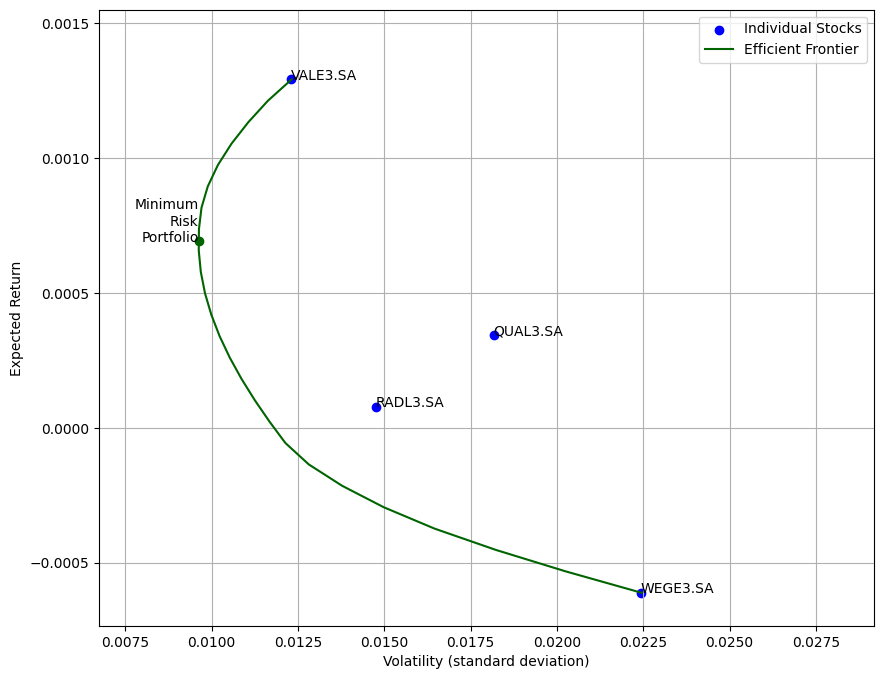

In [ ]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()